In [1]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from utils.common import sigmoid, reverse_sigmoid
from utils.constants import *
from utils.extraction_helpers import read_file

In [3]:
%load_ext autoreload
%autoreload

### Gambling1

In [4]:
chris  = read_file(f"{SUBMISSION_DATA_PATH}/sorted_chris.csv")
waikey = read_file(f"{SUBMISSION_DATA_PATH}/wk_seed_6666.csv")
ensemble = read_file(f"{SUBMISSION_DATA_PATH}/others_ensemble.csv")
exp_ensemble = read_file(f"{SUBMISSION_DATA_PATH}/others_exponential_ensemble.csv")
blend_trees = read_file(f"{SUBMISSION_DATA_PATH}/others_blend_boosted_tree.csv")

Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)


In [5]:
waikey["sigmoid_prediction"] = waikey["prediction"].apply(sigmoid)
chris["reverse_sigmoid_prediction"] = chris["prediction"].apply(reverse_sigmoid)
ensemble["reverse_sigmoid_prediction"] = ensemble["prediction"].apply(reverse_sigmoid)
exp_ensemble["reverse_sigmoid_prediction"] = exp_ensemble["prediction"].apply(reverse_sigmoid)
blend_trees["reverse_sigmoid_prediction"] = blend_trees["prediction"].apply(reverse_sigmoid)

In [6]:
pre_blend_df = pd.DataFrame(
    dict(
        wk=waikey["sigmoid_prediction"],
        chris=chris["prediction"],
        ensemble=ensemble["prediction"],
        exp_ensemble=exp_ensemble["prediction"],
        blend_trees=blend_trees["prediction"]
    )
)

In [7]:
mscaler = MinMaxScaler()
s1 = mscaler.fit_transform(pre_blend_df[["ensemble"]])[:, 0]
s2 = mscaler.fit_transform(pre_blend_df[["blend_trees"]])[:, 0]

In [8]:
pre_blend_df["tree_ensemble"] = 0.5 * (s1 + s2)
pre_blend_df = pre_blend_df.drop(columns=["blend_trees", "ensemble"], errors="ignore")

In [9]:
mscaler = MinMaxScaler()
pre_blend_df["exp_ensemble"] = mscaler.fit_transform(pre_blend_df[["exp_ensemble"]])[:, 0]

In [10]:
pre_blend_df.corr()

,wk,chris,exp_ensemble,tree_ensemble
wk,1.000000,0.975540,0.984327,0.996770
chris,0.975540,1.000000,0.979640,0.975682
exp_ensemble,0.984327,0.979640,1.000000,0.990506
tree_ensemble,0.996770,0.975682,0.990506,1.000000


In [19]:
pre_blend_df["final1"] = (
    0.55 * pre_blend_df["wk"] + 0.15 * (pre_blend_df["chris"] + pre_blend_df["tree_ensemble"] + pre_blend_df["exp_ensemble"])
)

In [20]:
gambling1 = read_file(f"{SUBMISSION_DATA_PATH}/gambling1_0.801.csv")

Shape of data: (924621, 2)


In [22]:
assert (pre_blend_df["final1"] - gambling1["prediction"]).max() < 1e-10

### Gambling4

In [127]:
chris  = read_file(f"{SUBMISSION_DATA_PATH}/sorted_chris.csv")
waikey = read_file(f"{SUBMISSION_DATA_PATH}/wk_seed_923_6666.csv")
ensemble = read_file(f"{SUBMISSION_DATA_PATH}/others_ensemble.csv")
exp_ensemble = read_file(f"{SUBMISSION_DATA_PATH}/others_exponential_ensemble.csv")
blend_trees = read_file(f"{SUBMISSION_DATA_PATH}/others_blend_boosted_tree.csv")

Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)
Shape of data: (924621, 2)


In [128]:
waikey["sigmoid_prediction"] = waikey["prediction"].apply(sigmoid)

In [129]:
pre_blend_df = pd.DataFrame(
    dict(
        wk=waikey["sigmoid_prediction"],
        chris=chris["prediction"],
        ensemble=ensemble["prediction"],
        exp_ensemble=exp_ensemble["prediction"],
        blend_trees=blend_trees["prediction"]
    )
)

In [130]:
mscaler = MinMaxScaler()
s1 = mscaler.fit_transform(pre_blend_df[["ensemble"]])[:, 0]
s2 = mscaler.fit_transform(pre_blend_df[["blend_trees"]])[:, 0]
pre_blend_df["tree_ensemble"] = 0.5 * (s1 + s2)
pre_blend_df = pre_blend_df.drop(columns=["blend_trees", "ensemble"], errors="ignore")

In [133]:
pre_blend_df["exp_ensemble"] = np.log(pre_blend_df["exp_ensemble"])

In [136]:
mscaler = MinMaxScaler()
pre_blend_df["exp_ensemble"] = mscaler.fit_transform(pre_blend_df[["exp_ensemble"]])[:, 0]

In [137]:
pre_blend_df.corr()

,wk,chris,exp_ensemble,tree_ensemble
wk,1.000000,0.975652,0.886442,0.996895
chris,0.975652,1.000000,0.920305,0.975682
exp_ensemble,0.886442,0.920305,1.000000,0.898017
tree_ensemble,0.996895,0.975682,0.898017,1.000000


In [141]:
pre_blend_df_copy = pre_blend_df.round(4).rank(method="dense").rank(pct=True)

In [143]:
pre_blend_df_copy["final1"] = (
    0.55 * pre_blend_df_copy["wk"] + 0.15 * (pre_blend_df_copy["chris"] + pre_blend_df_copy["tree_ensemble"] + pre_blend_df_copy["exp_ensemble"])
)

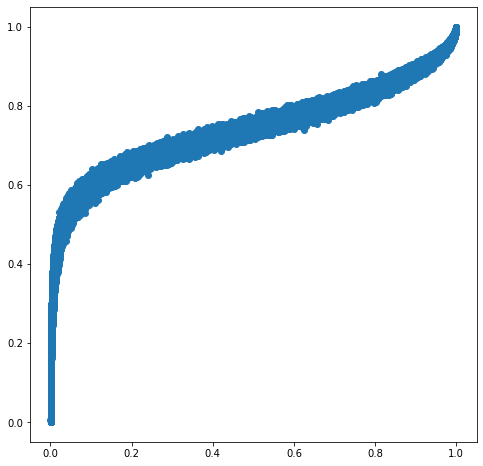

In [144]:
fig, ax = plt.subplots(figsize=(8, 8))
# plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="orange", linestyle="-")
# plt.xlabel("WK Blend")
# plt.ylabel("Chris best NN")
# plt.scatter(pre_blend_df["ensemble"], pre_blend_df["blend_trees"])
plt.scatter(pre_blend_df["wk"], pre_blend_df_copy["final1"])
# plt.scatter(s2, s1)
plt.show()

In [145]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = pre_blend_df_copy["final1"].values
sub.to_csv(f"{SUBMISSION_DATA_PATH}/gambling4.csv", index=False)

In [147]:
gambling4 = read_file(f"{SUBMISSION_DATA_PATH}/gambling4_0.800.csv")

Shape of data: (924621, 2)


In [149]:
assert (pre_blend_df_copy["final1"] - gambling4["prediction"]).max() < 1e-10

### Next

In [ ]:
np.corrcoef(pre_blend_df["final1"], gambling1["prediction"])

array([[1.        , 0.99982234],
       [0.99982234, 1.        ]])

In [98]:
# assert (pre_blend_df["final1"] - gambling1["prediction"]).max() < 1e-10

In [131]:
# fig, ax = plt.subplots(figsize=(8, 8))
# # plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color="orange", linestyle="-")
# # plt.xlabel("WK Blend")
# # plt.ylabel("Chris best NN")
# plt.scatter(pre_blend_df["exp_ensemble"], pre_blend_df["final1"])
# # plt.scatter(pre_blend_df["chris"], pre_blend_df["final"])
# # plt.scatter(pre_blend_df["tree_ensemble"], pre_blend_df["final"])
# # plt.scatter(pre_blend_df["exp_ensemble"], pre_blend_df["final"])
# # plt.scatter(ensemble["prediction"], blend_trees["prediction"])
# # plt.scatter(s1, s3)
# plt.show()

In [47]:
# result_sub1 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission105_blend_with_4seeds_hope_for_0.801_again.csv")
# result_sub1["prediction"] = result_sub1["prediction"].apply(reverse_sigmoid)

In [48]:
# result_sub2 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/chris_nn_0.7933788_custom_embed.csv")
# result_sub2 = result_sub2.sort_values(by="customer_ID").reset_index(drop=True)
result_sub2["prediction"] = result_sub2["prediction"].apply(reverse_sigmoid)

In [54]:
# result_sub2["prediction"] = pd.Series(s2).apply(sigmoid)

In [55]:
# result_sub1["prediction"] = np.where(result_sub1["prediction"] > 15, 10, result_sub1["prediction"])
# result_sub1["prediction"] = np.where(result_sub1["prediction"] < -15, -10, result_sub1["prediction"])

In [68]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")

In [69]:
sub["prediction"] = (
    0.53 * result_sub1["prediction"] + 0.13 * result_sub2["prediction"] 
    + 0.13 * result_sub3["prediction"] + 0.21 * result_sub4["prediction"]
)

In [70]:
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_blend_my_team_best_with_exponential_ensemble_5th.csv", index=False)

In [67]:
# np.corrcoef(sub["me"], sub["other"])

In [60]:
sub.describe()

,me,other
count,924621.000000,924621.000000
mean,-2.940645,-1.208755
std,3.575642,1.337941
min,-10.053445,-3.184661
25%,-5.984249,-2.302388
50%,-3.704030,-1.459412
75%,-0.120470,-0.086237
max,8.281089,1.382695


In [61]:
np.corrcoef(result_sub2["prediction"], result_sub1["prediction"])

array([[1.       , 0.9895066],
       [0.9895066, 1.       ]])

In [105]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = 0.8 * s1 + 0.2 * s2
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_109th_blend_best_with_chris_min_max_scaler.csv", index=False)

#### Take weighted average of 2 prediction scores

In [52]:
merged_result["prediction"] = merged_result["prediction_x"].rank() * 0.7 + merged_result["prediction_y"].rank() * 0.3
# merged_result["prediction"] = 0.6 * merged_result["prediction_x"] + 0.4 * merged_result["prediction_y"]

In [53]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"], errors="ignore")

In [54]:
if merged_result.shape == (924621, 2) and merged_result.columns.tolist() == ['customer_ID', 'prediction']:
    merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission31.csv", index=False)

In [ ]:
ori_columns = pre_blend_df.columns.tolist()

In [ ]:
pre_blend_df["simple_average"] = pre_blend_df[ori_columns].mean(axis=1)

In [ ]:
pre_blend_df[ori_columns]

,wk,chris,exp_ensemble,tree_ensemble
0,0.017929,0.050863,0.203048,0.069515
1,0.000551,0.001664,0.019959,0.005645
2,0.031305,0.027053,0.208046,0.071866
3,0.206866,0.688397,0.366104,0.235737
4,0.883933,0.949558,0.872776,0.861400
...,...,...,...,...
924616,0.014923,0.045180,0.121147,0.042261
924617,0.893580,0.931766,0.842889,0.820062
924618,0.449637,0.717965,0.570566,0.486275
924619,0.285664,0.552849,0.415526,0.289983


In [127]:
# pre_blend_df[ori_columns].rank()